<a href="https://colab.research.google.com/github/Korsholm22/Group_assignment_DeepLearning/blob/main/M4_Group_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**TASK**
- Build, train, and evaluate a neural network with Pytorch.
- It should have minimum 2 hidden layers
- Experiment with at least 5 different variations of hyperparameters (n layers / neurons, activation function, epochs, optimizers, learning rate etc.).
- Use gradio to build a simple interactive demo (in the notebook).

This should include:

1. Feature selection
2. Feature engineering (if necessary)
3. Standard ML preprocessing (if necessary)
4. Train-test split.
5. Defining a neural network architecture in putorch
6. Define a training loop.
7. training the model.
8. Try out different hyperparameters.
9. Evaluate the final model on the test data.
10. Visualize results with Grad.io

# Imports

In [89]:
# Importing libraries
import pandas as pd
import numpy as np 
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from statistics import mean
from sklearn.preprocessing import StandardScaler

In [2]:
# Importing dataset from M1 (SML APPLICATIONS - AIRBNB PRICING)
data = pd.read_csv('http://data.insideairbnb.com/denmark/hovedstaden/copenhagen/2022-06-24/data/listings.csv.gz')

In [3]:
# Examining the dataset
data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6983,https://www.airbnb.com/rooms/6983,20220624204326,2022-06-25,Copenhagen 'N Livin',Lovely apartment located in the hip Nørrebro a...,"Nice bars and cozy cafes just minutes away, ye...",https://a0.muscache.com/pictures/42044170/f63c...,16774,https://www.airbnb.com/users/show/16774,...,4.89,4.72,4.70,NaN,f,1,1,0,0,1.10
1,26057,https://www.airbnb.com/rooms/26057,20220624204326,2022-06-25,Lovely house - most attractive area,Our lovely house in the center of the city is ...,The neighborhood is the most famous one and th...,https://a0.muscache.com/pictures/miso/Hosting-...,109777,https://www.airbnb.com/users/show/109777,...,4.85,4.94,4.81,NaN,f,1,1,0,0,0.56
2,26473,https://www.airbnb.com/rooms/26473,20220624204326,2022-06-25,City Centre Townhouse Sleeps 1-10 persons,GUESTHOUSE ON KNABROSTRÆDE - located in the ab...,NaN,https://a0.muscache.com/pictures/8e132ba0-b68c...,112210,https://www.airbnb.com/users/show/112210,...,4.69,4.88,4.60,NaN,f,11,6,5,0,2.06
3,29118,https://www.airbnb.com/rooms/29118,20220624204326,2022-06-25,Best Location in Cool Istedgade,<b>The space</b><br />The apartment is situate...,NaN,https://a0.muscache.com/pictures/b83c7003-367a...,125230,https://www.airbnb.com/users/show/125230,...,5.00,4.85,4.77,NaN,f,1,1,0,0,0.15
4,670820,https://www.airbnb.com/rooms/670820,20220624204326,2022-06-25,1 Bedroom Apartment 5 min to Centre,The flat is located close to the city center -...,The flat is surrounded by parks and streets th...,https://a0.muscache.com/pictures/91442571/8563...,1566921,https://www.airbnb.com/users/show/1566921,...,4.88,4.88,4.25,NaN,f,1,1,0,0,0.10


# Preprocessing

In [4]:
# Converting price from an object to a float
data['price'] = data.price.str.replace('$','')
data['price'] = data.price.str.replace(',','')
data['price'] = data['price'].astype('float')

<ipython-input-4-90af22cc24d0>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['price'] = data.price.str.replace('$','')


In [5]:
# Converting instant_bookable from an object to a boolean
mapping = {'f':False,'t':True}
data.replace({"instant_bookable":mapping}, inplace=True)

In [6]:
# Keeping only airbnb's where the standard deviation of price is less than 2
data['price_z'] = (data['price'] - data['price'].mean())/data['price'].std(ddof=0)
data['price_z'] = data['price_z'].abs()
data = data[data.price_z < 2]

In [7]:
# Keeping only airbnb's which have received 1 or more reviews in the last 30 days
# Keeping only airbnb's which have a review score rating of 4 or more
data = data[data.number_of_reviews_l30d >= 1]
data = data[data.review_scores_rating >= 4]

In [8]:
# Seleting features from the dataset to be used as inputs and output in the neural network
selected_df = data[['instant_bookable','accommodates', 'beds', 'minimum_nights_avg_ntm', 'price']]

In [9]:
# Dropping NaN values
selected_df = selected_df.dropna()

In [10]:
# Defining X
X = selected_df.iloc[:,:-1]

In [11]:
# Defining y
y = selected_df.price

In [12]:
# Scaling numerical values by instantiating the scaler, fitting it onto X and inserting the scaled values in X
scaler = StandardScaler()
transformed_nummerical = scaler.fit_transform(X)
X.iloc[:,0:] = transformed_nummerical

In [13]:
# Splitting the data intro train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# Converting the training and test sets to tensors

# Training sets
X_train = torch.tensor(X_train[['instant_bookable', 'accommodates', 'beds', 'minimum_nights_avg_ntm']].values.astype(np.float32))
y_train = torch.tensor(y_train.values.astype(np.float32))

# Test sets
X_test = torch.tensor(X_test[['instant_bookable', 'accommodates', 'beds', 'minimum_nights_avg_ntm']].values.astype(np.float32))
y_test = torch.tensor(y_test.values.astype(np.float32))

In [15]:
# Examining the size of the tensors
print('Training sets:')
print(X_train.size())
print(y_train.size())

print('')

print('Test sets:')
print(X_test.size())
print(y_test.size())

Training sets:
torch.Size([3170, 4])
torch.Size([3170])

Test sets:
torch.Size([793, 4])
torch.Size([793])


# Default Network

First, we copy/paste example 5 from 'Exercise Session 1 ANN Pytorch Solution: 5. Training ANN through Customer churn dataset with 4 inputs and 2 hidden layers' as a default model for further experimentation with hyperparameters.

Based on these hyperparameters the minimal loss is: 1,829,178.0

In [16]:
epochs = 50
learning_rate = 0.01
loss_set = {}

# 1. Creating a FeedForwardNetwork
default = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,1),
                         torch.nn.Sigmoid()
                         );
optimizer = torch.optim.RMSprop(default.parameters(), lr=learning_rate)
loss_mse = torch.nn.MSELoss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = default.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_mse(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-16-2cba45d1cd84>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 1829179.0
Loss: 1829178.0
Loss: 1829178.0
Loss: 1829178.0
Loss: 1829178.0


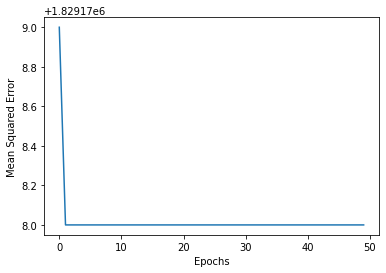

In [17]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

# Experiments

Based on the following overview, we may experiment with different loss functions, optimization algorithms, activation functions, number of hidden layers, number of epochs and learning rates depending on the type of neural network and the problem being solved.

![](https://raw.github.com/Korsholm22/Group_assignment_DeepLearning/main/Illustrations/Neural%20Network%20Overview.jpg)

## Experiment 1: Activation Function

Since we are working with a regression problem (pricing of airbnb's), we change the activation function of the output layer to nn.Identity according to the overview above.

Based on these hyperparameters the minimal loss is: 322,528.5

Changes compared to default network:

- Output layer activation function changed to Identity

In [18]:
epochs = 50
learning_rate = 0.01
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_1 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_1.parameters(), lr=learning_rate)
loss_mse = torch.nn.MSELoss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_1.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_mse(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-18-59c4e6ab0def>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss: 412381.75
Loss: 323631.90625
Loss: 323208.9375
Loss: 322901.125
Loss: 322528.5


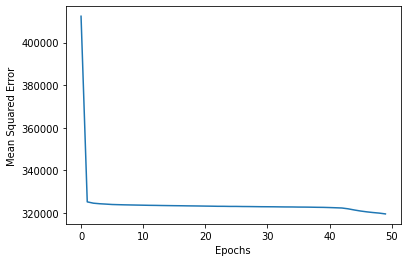

In [19]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

## Experiment 2: Loss Function

Since we are working with a regression problem, we can also use the loss function L1 for evaluating the network.

Based on these hyperparameters the minimal loss is: 393.0252685546875


Changes compared to default network:

- Output layer activation function changed to Identity
- Loss function changed to L1 Loss

In [28]:
epochs = 50
learning_rate = 0.01
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_2 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_2.parameters(), lr=learning_rate)
loss_l1 = torch.nn.L1Loss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_2.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_l1(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-28-9bff6d51a451>:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loss: 428.0741271972656
Loss: 393.85101318359375
Loss: 393.3807067871094
Loss: 393.1479187011719
Loss: 393.0252685546875


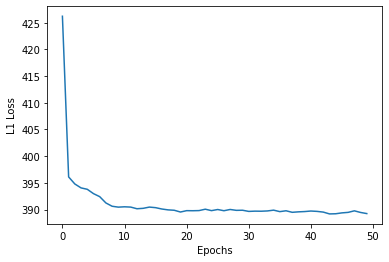

In [21]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.show()

## Experiment 3: Hidden Layers

Increasing the number of hidden layers in the network may improve performance depending on the complexity of the problem being solved. We therefore try to increase the number of hidden layers from 2 to 3.

Based on these hyperparameters the minimal loss is: 392.8772888183594

Changes compared to default network:

- Output layer activation function changed to Identity
- Loss function changed to L1 Loss
- Number of hidden layers increased from 2 to 3

In [22]:
epochs = 50
learning_rate = 0.01
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_3 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,8),
                         torch.nn.ReLU(),
                         torch.nn.Linear(8,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_3.parameters(), lr=learning_rate)
loss_l1 = torch.nn.L1Loss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_3.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_l1(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-22-29e376988c95>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loss: 415.09722900390625
Loss: 395.33233642578125
Loss: 393.404541015625
Loss: 393.3476257324219
Loss: 392.8772888183594


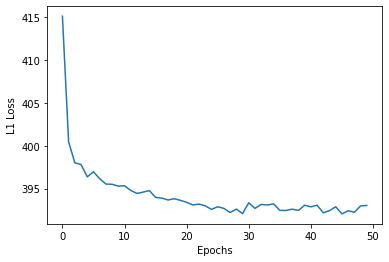

In [23]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.show()

## Experiment 4: Epochs

The number of epochs determines how many times the weights of the network are changed and the boundary goes from underfitting to optimal to overfitting. We therefore try to increase the number of epochs from 50 to 100.

Based on these hyperparameters the minimal loss is: 388.9616394042969


Changes compared to default network:

- Output layer activation function changed to Identity
- Loss function changed to L1 Loss
- Number of hidden layers increased from 2 to 3
- Number of epochs increased from 50 to 150


In [24]:
epochs = 150
learning_rate = 0.01
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_4 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,8),
                         torch.nn.ReLU(),
                         torch.nn.Linear(8,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_4.parameters(), lr=learning_rate)
loss_l1 = torch.nn.L1Loss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_4.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_l1(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-24-fd571ffeed3d>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/150 [00:00<?, ?epoch/s]

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loss: 417.4961242675781
Loss: 395.67669677734375
Loss: 393.81268310546875
Loss: 392.7497253417969
Loss: 391.1744384765625
Loss: 390.65643310546875
Loss: 391.06103515625
Loss: 390.5394287109375
Loss: 390.0340576171875
Loss: 389.2911376953125
Loss: 389.81610107421875
Loss: 389.8424377441406
Loss: 390.142578125
Loss: 388.9616394042969
Loss: 388.9736328125


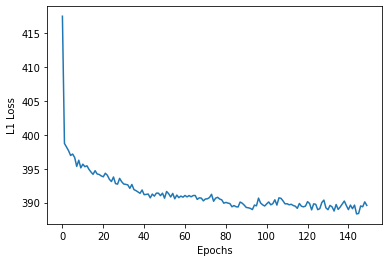

In [25]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.show()

## Experiment 5: Learning Rate

The learning rate controls how much the model is changed in response to the estimated error each time the model weights are updated. A rate too small may result in a long training process while a rate too large may result in a sub-optimal set of weights or an unstable training process. We therefore try to decrease the learning rate from 0.01 to 0.001

Based on these hyperparameters the minimal loss is: Loss: 386.041748046875

Changes compared to default network:

- Output layer activation function changed to Identity
- Loss function changed to L1 Loss
- Number of hidden layers increased from 2 to 3
- Number of epochs increased rom 50 to 150
- Learning rate decreased from 0.01 to 0.001


In [29]:
epochs = 150
learning_rate = 0.001
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_5 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,8),
                         torch.nn.ReLU(),
                         torch.nn.Linear(8,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_5.parameters(), lr=learning_rate)
loss_l1 = torch.nn.L1Loss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_5.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_l1(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-29-29ac3d128a81>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/150 [00:00<?, ?epoch/s]

Loss: 657.9803466796875
Loss: 390.472412109375
Loss: 389.9311218261719
Loss: 389.7992858886719
Loss: 389.7226257324219
Loss: 389.55712890625
Loss: 389.46734619140625
Loss: 389.2889099121094
Loss: 389.26849365234375
Loss: 389.0031433105469
Loss: 388.6266174316406
Loss: 388.149169921875
Loss: 387.2118225097656
Loss: 386.4511413574219
Loss: 386.041748046875


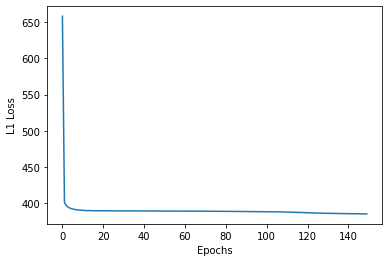

In [30]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('L1 Loss')
plt.show()

## Experiment 6: Loss Function

Seeing how the number of hidden layers, number of epochs and learning rate improved the loss function in experiment 2-5 above, which all used L1 Loss for evaluating the network, we try to change the loss function back to MSE to examine if these changes have the same influencn when using this loss function for network evaluation.

Based on these hyperparameters the minimal loss is: 318,430.25

Changes compared to default network:

- Output layer activation function changed to Identity
- Loss function changed back to MSE Loss
- Number of hidden layers increased from 2 to 3
- Number of epochs increased rom 50 to 150
- Learning rate decreased from 0.01 to 0.001


In [81]:
epochs = 150
learning_rate = 0.001
loss_set = {}

# 1. Creating a FeedForwardNetwork
experiment_6 = torch.nn.Sequential(
                         torch.nn.Linear(4,6),
                         torch.nn.ReLU(),
                         torch.nn.Linear(6,5),
                         torch.nn.ReLU(),
                         torch.nn.Linear(5,8),
                         torch.nn.ReLU(),
                         torch.nn.Linear(8,1),
                         torch.nn.Identity()
                         );
optimizer = torch.optim.RMSprop(experiment_6.parameters(), lr=learning_rate)
loss_mse = torch.nn.MSELoss()


for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      lost_set_epoch = {}
      j = 0
      for x, y_t in zip(X_train, y_train):
          output = experiment_6.forward(x.float())

          # 2. FeedForward Evaluation
          loss = loss_mse(output, y_t.float())
          optimizer.zero_grad()

          # 3. Backward / Gradient Calculation
          loss.backward()

          # 4. Back Propagation
          optimizer.step()

          # Display_loss:
          lost_set_epoch[j] = loss
          j = j + 1
      
      loss_set[i] = torch.mean(torch.stack(list(lost_set_epoch.values()))).detach().numpy()
      if (i % 10)==0:
         print (f"Loss: {loss_set[i]}")

<ipython-input-81-a190c4754df3>:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/150 [00:00<?, ?epoch/s]

Loss: 909034.6875
Loss: 321396.15625
Loss: 319852.4375
Loss: 319335.5
Loss: 318990.6875
Loss: 318831.96875
Loss: 318763.71875
Loss: 318693.6875
Loss: 318662.25
Loss: 318660.8125
Loss: 318614.34375
Loss: 318566.0625
Loss: 318525.90625
Loss: 318483.03125
Loss: 318430.25


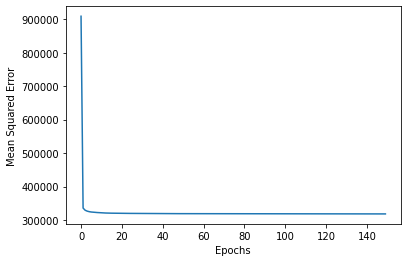

In [106]:
# Plotting the loss function
plt.plot(np.array(list(loss_set.values())).astype(float))
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.show()

# Evaluating the Models on Test Data

Note that all models are saved and uploaded in the Github repository

In [101]:
# Saving the trained models
torch.save(default, 'default.pkl')
torch.save(experiment_1, 'experiment_1.pkl')
torch.save(experiment_2, 'experiment_2.pkl')
torch.save(experiment_3, 'experiment_3.pkl')
torch.save(experiment_4, 'experiment_4.pkl')
torch.save(experiment_5, 'experiment_5.pkl')
torch.save(experiment_6, 'experiment_6.pkl')

In [102]:
# Loading the models
default = torch.load('default.pkl')
experiment_1 = torch.load('experiment_1.pkl')
experiment_2 = torch.load('experiment_2.pkl')
experiment_3 = torch.load('experiment_3.pkl')
experiment_4 = torch.load('experiment_4.pkl')
experiment_5 = torch.load('experiment_5.pkl')
experiment_6 = torch.load('experiment_6.pkl')

In [103]:
# Applying the models to test data
default = default(X_test)
experiment_1 = experiment_1(X_test)
experiment_2 = experiment_2(X_test)
experiment_3 = experiment_3(X_test)
experiment_4 = experiment_4(X_test)
experiment_5 = experiment_5(X_test)
experiment_6 = experiment_6(X_test)

TypeError: ignored

In [107]:
# Converting the tensors to lists to calculate R^2 and MSE
y_test_list = y_test.detach().numpy()

default_list = default.detach().numpy()
experiment_1_list = experiment_1.detach().numpy()
experiment_2_list = experiment_2.detach().numpy()
experiment_3_list = experiment_3.detach().numpy()
experiment_4_list = experiment_4.detach().numpy()
experiment_5_list = experiment_5.detach().numpy()
experiment_6_list = experiment_6.detach().numpy()

AttributeError: ignored

In [86]:
# Calculating R^2 for each model
default_r2 = r2_score(y_test_list, default_list)
experiment_1_r2 = r2_score(y_test_list, experiment_1_list)
experiment_2_r2 = r2_score(y_test_list, experiment_2_list)
experiment_3_r2 = r2_score(y_test_list, experiment_3_list)
experiment_4_r2 = r2_score(y_test_list, experiment_4_list)
experiment_5_r2 = r2_score(y_test_list, experiment_5_list)
experiment_6_r2 = r2_score(y_test_list, experiment_6_list)

In [78]:
print('default_r2: ' + str(default_r2))
print('experiment_1_r2: ' + str(experiment_1_r2))
print('experiment_2_r2: ' + str(experiment_2_r2))
print('experiment_3_r2: ' + str(experiment_3_r2))
print('experiment_4_r2: ' + str(experiment_4_r2))
print('experiment_5_r2: ' + str(experiment_5_r2))
print('experiment_6_r2: ' + str(experiment_6_r2))

-2.7860820860994364
0.3625855038740169
0.29760594903975
0.2583086468828768
0.30563281222030403
0.3156096737038093


In [96]:
# Calculating MSE for each model
default_mse = mean_squared_error(y_test_list, default_list)
experiment_1_mse = mean_squared_error(y_test_list, experiment_1_list)
experiment_2_mse = mean_squared_error(y_test_list, experiment_2_list)
experiment_3_mse = mean_squared_error(y_test_list, experiment_3_list)
experiment_4_mse = mean_squared_error(y_test_list, experiment_4_list)
experiment_5_mse = mean_squared_error(y_test_list, experiment_5_list)
experiment_6_mse = mean_squared_error(y_test_list, experiment_6_list)

In [97]:
print('default_mse: ' + str(default_mse))
print('experiment_1_mse: ' + str(experiment_1_mse))
print('experiment_2_mse: ' + str(experiment_2_mse))
print('experiment_3_mse: ' + str(experiment_3_mse))
print('experiment_4_mse: ' + str(experiment_4_mse))
print('experiment_5_mse: ' + str(experiment_5_mse))
print('experiment_6_mse: ' + str(experiment_6_mse))

default_mse: 2045416.1
experiment_1_mse: 344360.72
experiment_2_mse: 379465.7
experiment_3_mse: 400695.84
experiment_4_mse: 375129.2
experiment_5_mse: 369739.22
experiment_6_mse: 343438.6


# Gradio Visualization

In [127]:
!pip install -q gradio
import gradio as gradio

In [128]:
def greet(name):
  return "Hello " + name + "!"

greet("World")

'Hello World!'

In [129]:
gradio.Interface(greet, "text", "text").launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2d03e8b3-e4d0-48a6.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
